In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
# notebook parameters
input_dataset_path = 'data/heart.csv'

#### Functions

In [3]:
def model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train,y_train)
    ml_pred = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=1)
    print('Results for selected model')
    print(accuracy_score(y_test, ml_pred))
    print(classification_report(y_test, ml_pred))

    return ml_pred

In [4]:
heart_df = pd.read_csv(input_dataset_path)
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=['target']).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df['target'].unique()}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 1025 rows and 14 colums
Input dataset consists of 13 features and 1 target column
Target values are: [0 1]
Input dataset contains 723 duplicated rows and 302 unique rows


In [6]:
# divide a heart failure dataset into features and target value sets
x = heart_df.drop(columns=['target'])
y = heart_df['target']

In [7]:
# Select training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    random_state=12, 
                                                    test_size=0.25)

print(f"Training dataset consists of {x_train.shape[0]} records")
print(f"Test dataset consists of {x_test.shape[0]} records")

Training dataset consists of 768 records
Test dataset consists of 257 records


In [8]:
# some models are sensitive for feature value scale differences
# StandardScaler is used to transform those values into rescaled format, without information loss
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

In [9]:
# Transform target data sets into binary matrix representation of the target values
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

### Decision Tree

In [10]:
dt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')

dt_model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=11)

In [11]:
npr_dt_predictions = dt_model.predict(x_test)
print(f"Prediction accuracy for (non pruned) decision tree: {accuracy_score(y_test, npr_dt_predictions)}")

Prediction accuracy for (non pruned) decision tree: 1.0


[Text(0.4699292452830189, 0.95, 'x[2] <= -0.411\nentropy = 1.0\nsamples = 768\nvalue = [380, 388]'),
 Text(0.2641509433962264, 0.85, 'x[11] <= -0.269\nentropy = 0.788\nsamples = 382\nvalue = [292, 90]'),
 Text(0.16981132075471697, 0.75, 'x[12] <= 0.274\nentropy = 0.998\nsamples = 164\nvalue = [86, 78]'),
 Text(0.09433962264150944, 0.65, 'x[8] <= 0.32\nentropy = 0.824\nsamples = 93\nvalue = [24, 69]'),
 Text(0.03773584905660377, 0.55, 'x[0] <= 0.604\nentropy = 0.509\nsamples = 62\nvalue = [7, 55]'),
 Text(0.018867924528301886, 0.45, 'entropy = 0.0\nsamples = 41\nvalue = [0, 41]'),
 Text(0.05660377358490566, 0.45, 'x[0] <= 0.766\nentropy = 0.918\nsamples = 21\nvalue = [7, 14]'),
 Text(0.03773584905660377, 0.35, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.07547169811320754, 0.35, 'x[7] <= -2.211\nentropy = 0.672\nsamples = 17\nvalue = [3, 14]'),
 Text(0.05660377358490566, 0.25, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.09433962264150944, 0.25, 'entropy = 0.0\nsampl

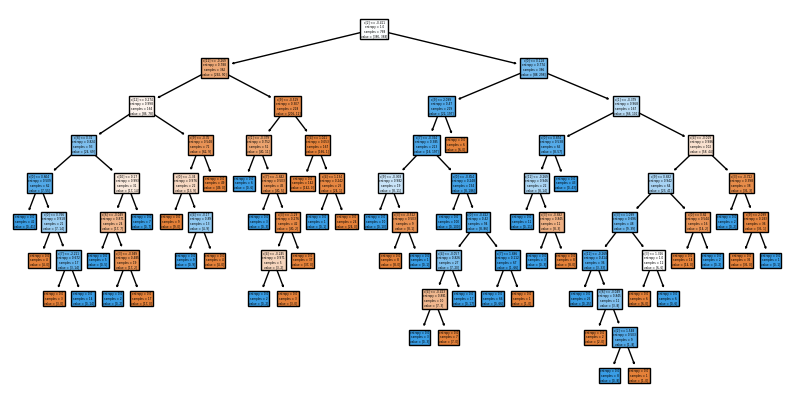

In [12]:
plt.figure(figsize=(10,5))
tree.plot_tree(dt_model,filled=True)

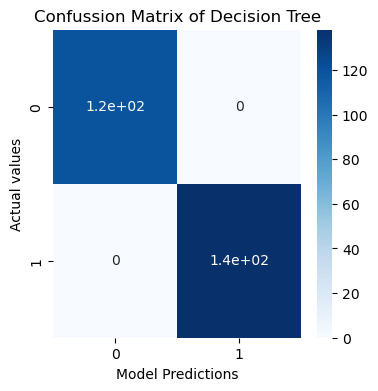

In [13]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, npr_dt_predictions)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Actual values')
plt.title('Confussion Matrix of Decision Tree')
plt.show()

### Pruning Decision Tree

In [14]:
base_pdt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')
ccp_path = base_pdt_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [15]:
pdt_models = []
for ccp_alpha in ccp_alphas:
    pdt_model = DecisionTreeClassifier(random_state=11,
                                       ccp_alpha=ccp_alpha)
    pdt_model.fit(x_train, y_train)

    # add Pruning Decision Tree classifier to list of trees
    pdt_models.append(pdt_model)

In [16]:
print(f"Last tree in list has {pdt_models[-1].tree_.node_count} for cpp_alpha parameter {ccp_alphas[-1]}")

Last tree in list has 1 for cpp_alpha parameter 0.21889506422498584


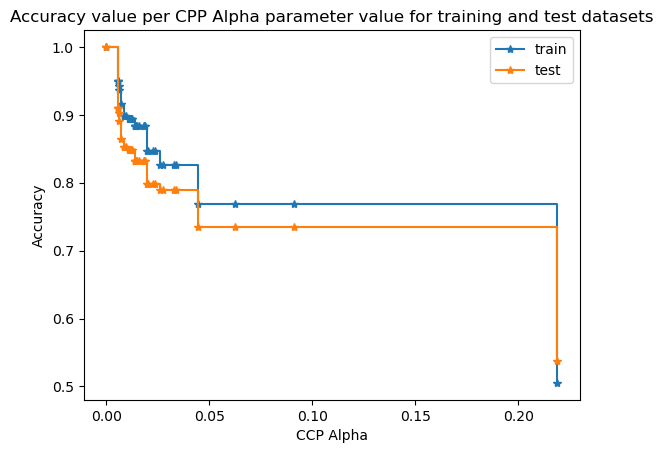

In [17]:
train_scores = [tree.score(x_train, y_train) for tree in pdt_models]
test_scores = [tree.score(x_test, y_test) for tree in pdt_models]

fig, ax = plt.subplots()
ax.set_xlabel("CCP Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy value per CPP Alpha parameter value for training and test datasets")
ax.plot(ccp_alphas, 
        train_scores, 
        marker='*', 
        label='train', 
        drawstyle="steps-post")
ax.plot(ccp_alphas, 
        test_scores, 
        marker='*', 
        label='test', 
        drawstyle="steps-post")
ax.legend()
plt.show()

In [18]:
pdt_model = DecisionTreeClassifier(random_state=11,
                             ccp_alpha=0.09, 
                             criterion='entropy')
pdt_model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.09, criterion='entropy', random_state=11)

In [19]:
pdt_predictions = pdt_model.predict(x_test)
print('Results for Pruning Decision Tree model')
print(accuracy_score(y_test, pdt_predictions))
print(classification_report(y_test, pdt_predictions))

Results for Pruning Decision Tree model
0.7354085603112841
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       119
           1       0.75      0.77      0.76       138

    accuracy                           0.74       257
   macro avg       0.73      0.73      0.73       257
weighted avg       0.74      0.74      0.74       257



[Text(0.6, 0.8333333333333334, 'x[2] <= -0.411\nentropy = 1.0\nsamples = 768\nvalue = [380, 388]'),
 Text(0.4, 0.5, 'x[11] <= -0.269\nentropy = 0.788\nsamples = 382\nvalue = [292, 90]'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.998\nsamples = 164\nvalue = [86, 78]'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.307\nsamples = 218\nvalue = [206, 12]'),
 Text(0.8, 0.5, 'entropy = 0.774\nsamples = 386\nvalue = [88, 298]')]

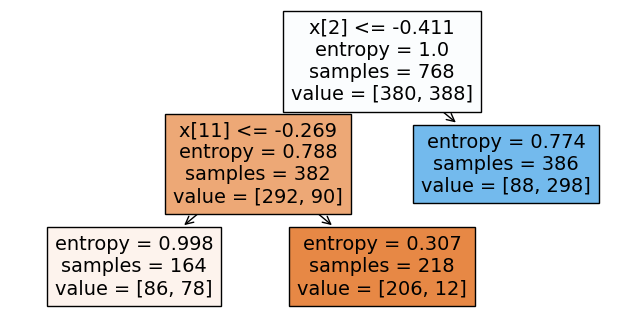

In [20]:
plt.figure(figsize=(8,4))
tree.plot_tree(pdt_model, filled=True)

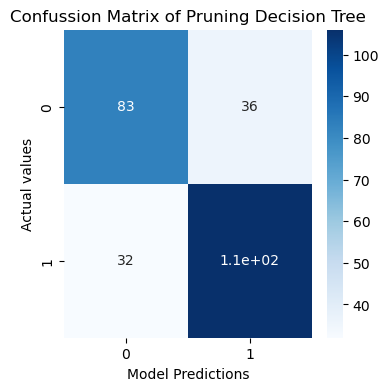

In [21]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, pdt_predictions)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Actual values')
plt.title('Confussion Matrix of Pruning Decision Tree')
plt.show()

### Random Forest

In [22]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_samples_leaf=10,
                                  random_state=11,
                                  n_jobs=1)

rf_model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=0.5,
                       min_samples_leaf=10, n_jobs=1, random_state=11)

In [23]:
rf_predictions = rf_model.predict(x_test)
print('Results for Random Forest model')
print(accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Results for Random Forest model
0.8715953307392996
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       119
           1       0.87      0.90      0.88       138

    accuracy                           0.87       257
   macro avg       0.87      0.87      0.87       257
weighted avg       0.87      0.87      0.87       257



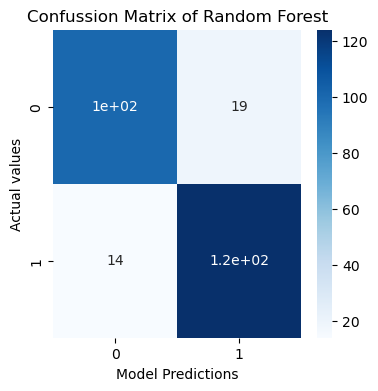

In [24]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, rf_predictions)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Actual values')
plt.title('Confussion Matrix of Random Forest')
plt.show()

### CNN model

In [25]:
cnn_model = Sequential()
cnn_model.add(Dense(256, 
                    input_dim=13, 
                    activation='relu'))
cnn_model.add(Dense(256, 
                    activation='relu'))
cnn_model.add(Dense(2, 
                    activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(f"CNN model summary: \n{cnn_model.summary()}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69890 (273.01 KB)
Trainable params: 69890 (273.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CNN model summary: 
None


In [26]:
cnn_model.fit(x_train, 
              y_cat_train, 
              epochs=10, 
              validation_data=(x_test, y_cat_test))

Epoch 1/10
24/24 [==============================] - 1s 11ms/step - loss: 0.3917 - accuracy: 0.8424 - val_loss: 0.3670 - val_accuracy: 0.8521
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2838 - accuracy: 0.8828 - val_loss: 0.3258 - val_accuracy: 0.8716
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2385 - accuracy: 0.9062 - val_loss: 0.2879 - val_accuracy: 0.8988
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2075 - accuracy: 0.9310 - val_loss: 0.2462 - val_accuracy: 0.9105
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.9453 - val_loss: 0.2341 - val_accuracy: 0.8988
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9492 - val_loss: 0.1938 - val_accuracy: 0.9339
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9648 - val_loss: 0.1515 - val_accuracy: 0.9455
Epoch 8/10
24/24 [=

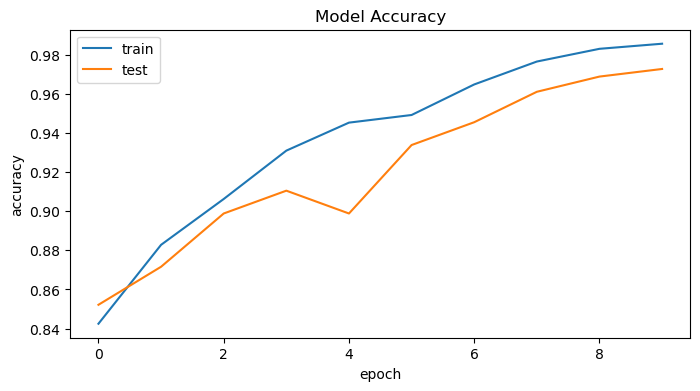

In [27]:
plt.figure(figsize=(8,4))
plt.plot(cnn_model.history.history['accuracy'])
plt.plot(cnn_model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

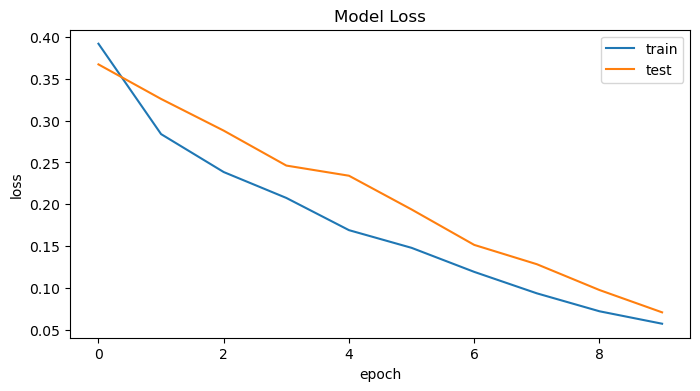

In [28]:
# Model Losss
plt.figure(figsize=(8,4))
plt.plot(cnn_model.history.history['loss'])
plt.plot(cnn_model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [29]:
print(f"CNN model evaluation after training: {cnn_model.evaluate(x_train, y_cat_train)}")
print (f"CNN model evaluation for test dataset: {cnn_model.evaluate(x_test, y_cat_test)}")

24/24 [==============================] - 0s 1ms/step - loss: 0.0432 - accuracy: 0.9948
CNN model evaluation after training: [0.04319968819618225, 0.9947916865348816]
9/9 [==============================] - 0s 1ms/step - loss: 0.0709 - accuracy: 0.9728
CNN model evaluation for test dataset: [0.07090826332569122, 0.9727626442909241]


In [30]:
# CNN model Heart Failure prediction for test dataset
cnn_prediction = cnn_model.predict(x_test)
prob_cnn_prediction = np.argmax(cnn_prediction, axis=1)

print('Results for CNN categorical model')
print(accuracy_score(y_test, prob_cnn_prediction))
print(classification_report(y_test, prob_cnn_prediction))

9/9 [==============================] - 0s 1ms/step
Results for CNN categorical model
0.9727626459143969
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       119
           1       0.96      0.99      0.97       138

    accuracy                           0.97       257
   macro avg       0.97      0.97      0.97       257
weighted avg       0.97      0.97      0.97       257



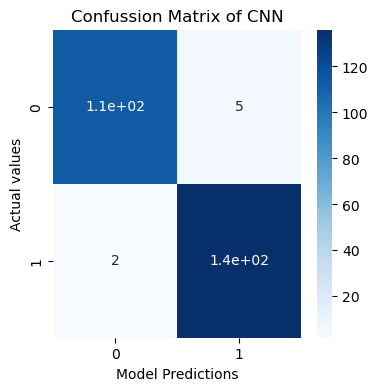

In [31]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, prob_cnn_prediction)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Actual values')
plt.title('Confussion Matrix of CNN')
plt.show()

### Logistic Regression

In [32]:
lr_model = LogisticRegression(random_state = 0,C=10,penalty= 'l2')
lr_predictions = model(lr_model, 
                       x_train=x_train,
                       y_train=y_train,
                       x_test=x_test, 
                       y_test=y_test)

Results for selected model
0.8210116731517509
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       119
           1       0.82      0.86      0.84       138

    accuracy                           0.82       257
   macro avg       0.82      0.82      0.82       257
weighted avg       0.82      0.82      0.82       257



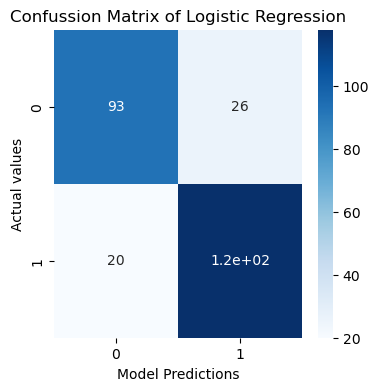

In [33]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, lr_predictions)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Actual values')
plt.title('Confussion Matrix of Logistic Regression')
plt.show()

### Support Vector Machine

In [34]:
svm_model = SVC(kernel = 'linear',C = 0.3)
svm_predictions = model(svm_model, 
                        x_train=x_train,
                        y_train=y_train, 
                        x_test=x_test, 
                        y_test=y_test)

Results for selected model
0.8054474708171206
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       119
           1       0.79      0.87      0.83       138

    accuracy                           0.81       257
   macro avg       0.81      0.80      0.80       257
weighted avg       0.81      0.81      0.80       257



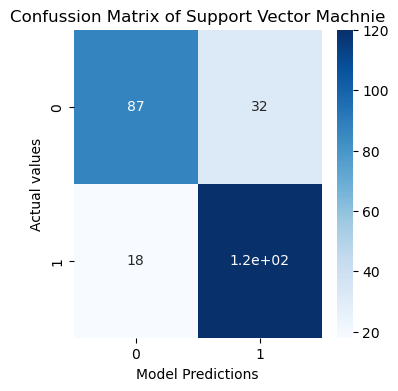

In [35]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, svm_predictions)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Actual values')
plt.title('Confussion Matrix of Support Vector Machnie')
plt.show()

### K Nearest Neighbours

In [36]:
knn_model = KNeighborsClassifier(leaf_size=1, n_neighbors=3)
knn_predictions = model(knn_model, 
                        x_train=x_train,
                        y_train=y_train, 
                        x_test=x_test, 
                        y_test=y_test)

Results for selected model
0.9299610894941635
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       119
           1       0.92      0.96      0.94       138

    accuracy                           0.93       257
   macro avg       0.93      0.93      0.93       257
weighted avg       0.93      0.93      0.93       257



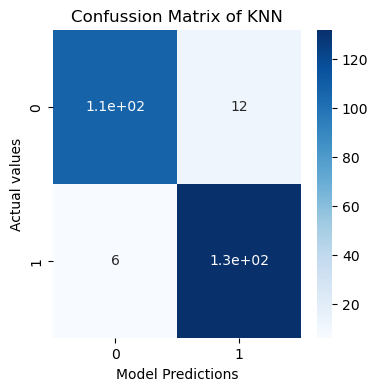

In [37]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(y_test, knn_predictions)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Actual values')
plt.title('Confussion Matrix of KNN')
plt.show()

### Comparison of models' results

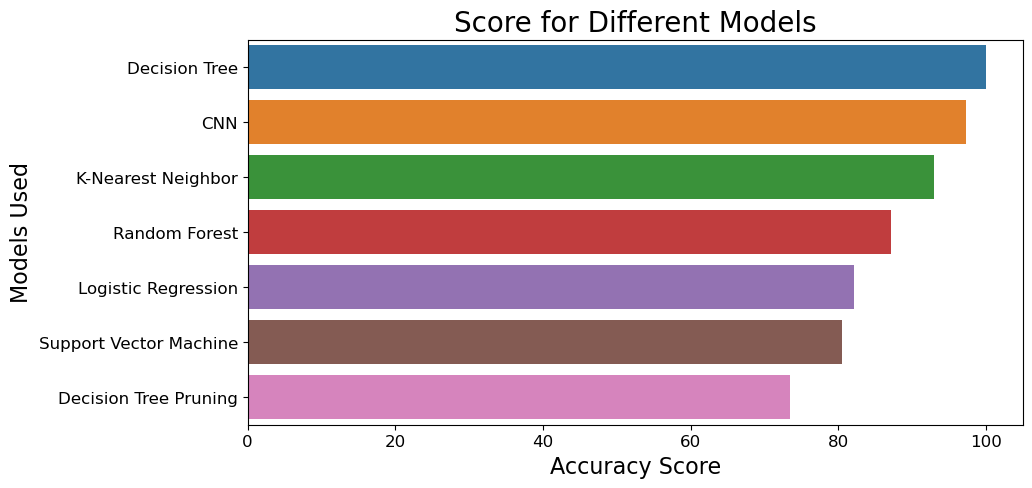

In [38]:
acc_scores = {
    'Decision Tree': accuracy_score(npr_dt_predictions, y_test) * 100, 
    'Decision Tree Pruning': accuracy_score(pdt_predictions, y_test) * 100, 
    'Random Forest': accuracy_score(rf_predictions, y_test) * 100, 
    'Logistic Regression': accuracy_score(lr_predictions, y_test) * 100,
    'Support Vector Machine': accuracy_score(svm_predictions, y_test) * 100, 
    'K-Nearest Neighbor': accuracy_score(knn_predictions, y_test) * 100,
    'CNN': accuracy_score(prob_cnn_prediction, y_test) * 100
}

acc_scores = dict(sorted(acc_scores.items(), key = lambda x: x[1], reverse = True))
models = list(acc_scores.keys())
score = list(acc_scores.values())

fig = plt.figure(figsize=(10, 5))
sns.barplot(x=score, y=models)
plt.xlabel("Accuracy Score", size = 16)
plt.xticks(size = 12)
plt.ylabel("Models Used", size = 16)
plt.yticks(size = 12)
plt.title("Score for Different Models", size = 20)
plt.show()